In [1]:
import sys
sys.path.insert(0,'../PLASIM/')
import Learn2_new as ln
ut = ln.ut # utilities
ef = ln.ef # ERA_Fields_New

# log to stdout
import logging
import os
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

# set spacing of the indentation
ut.indentation_sep = '  '

2023-02-21 19:51:35.252475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
Could not load field_infos: using the hardcoded version


In [21]:
import importlib as imp
imp.reload(ln)
imp.reload(ef)

path_to_ERA = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe'/ERA/
Could not load field_infos: using the hardcoded version
Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy
Successfully imported cartopy


<module 'ERA.ERA_Fields_New' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/ERA_Fields_New.py'>

In [3]:
import itertools as its

Months1 = [0, 0, 0, 0, 0, 0, 31, 30, 31, 31, 30, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(its.accumulate(Months1))
X, Y, yp, lat, lon = ln.prepare_data(**ut.set_values_recursive(ln.get_default_params(ln.prepare_data, recursive=True),
                                              {'fields': ['t2m','zg500','mrso'], 'year_list' : 'range(100)', 'mylocal' : '/local/gmiloshe/CESM/', 
                                               'time_start' : Tot_Mon1[6], 'time_end' : Tot_Mon1[9], # Take into account number of days per month in CESM
                                               #'lon_start' : - 288//2, 'lon_end' : 288//2,
                                               'lon_start' : -72, 'lon_end' : 56,
                                                'lat_end' : 192, 'lat_start' : 192-192*60//180, # latitudes start from 90 degrees North Pole
                                               'Model' : 'CESM', 'datafolder' : 'Data_CESM', 'dataset_years' : 1000, 'preprefix' : 'North_Anomalies_'}))
LON, LAT = ln.np.meshgrid(lon, lat)

prepare_data:
  load_data:
    Opening field TSA
    First valid path found in /local/gmiloshe/CESM/Data_CESM/North_Anomalies_TSA.nc
    monotonize_years:
    monotonize_years: completed in 0.7 s
    First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
    First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_cellarea.nc
    select_years:
    select_years: completed in 1.5 s
    sort_lat:
    sort_lat: completed in 0.0 s
    select_lonlat:
    select_lonlat: completed in 0.3 s
    First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
    Opening field Z3
    First valid path found in /local/gmiloshe/CESM/Data_CESM/North_Anomalies_Z3.500hPa.nc
    monotonize_years:
    monotonize_years: completed in 0.6 s
    First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
    First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_cellarea.nc
    select_years:
    select_years: completed in 1.4 s
    sort_lat:
    sort_lat: com

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fd30d517580>


/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/general_purpose/cartopy_plots.py:138: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


<GeoAxesSubplot:>

<Figure size 648x432 with 0 Axes>

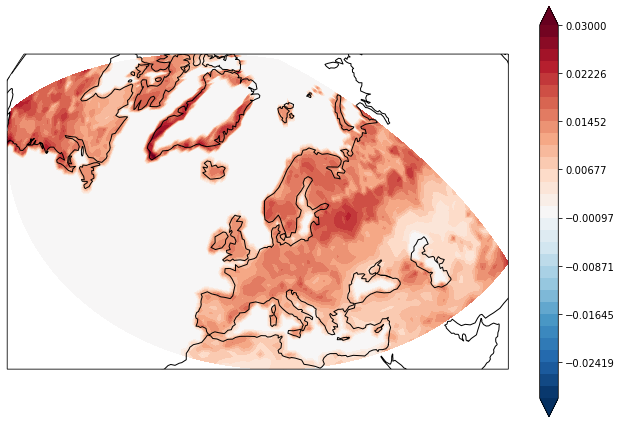

In [4]:
LON, LAT = ln.np.meshgrid(lon, lat)
import cartopy.crs as ccrs
import general_purpose.cartopy_plots as cplt
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.std(X,0)[...,2:3],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-0.03,0.03,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fd5441ffbb0>


<GeoAxesSubplot:>

<Figure size 648x432 with 0 Axes>

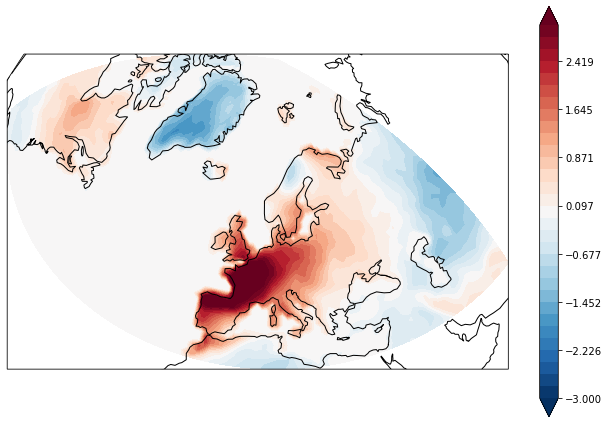

In [5]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,0:1],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-3,3,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fd309d7a370>


<GeoAxesSubplot:>

<Figure size 648x432 with 0 Axes>

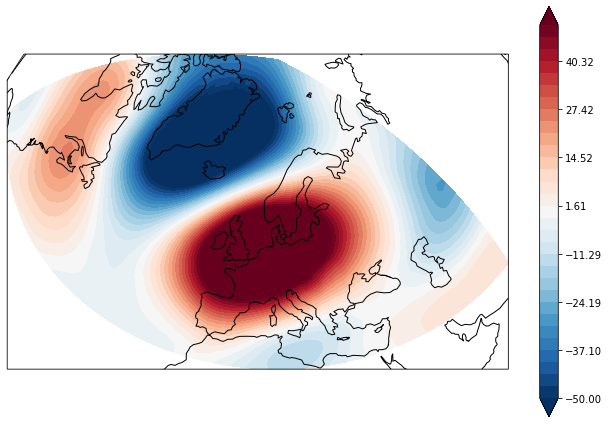

In [6]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,1:2],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-50,50,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

norm = <matplotlib.colors.TwoSlopeNorm object at 0x7fd30d1b6ac0>


<GeoAxesSubplot:>

<Figure size 648x432 with 0 Axes>

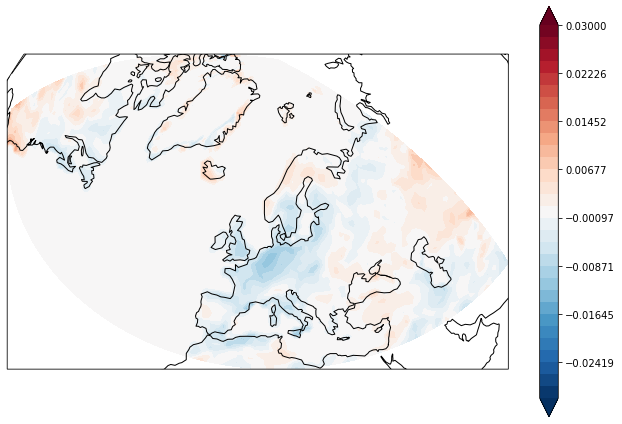

In [7]:
fig = plt.figure(figsize=(9,6))
cplt.multiple_field_plot2(LON, LAT, np.mean(X[Y==1],0)[...,2:3],projections=[ccrs.Orthographic(10, 55)],
                         fig_num=8, put_colorbar=True, use_norm=False, levs=np.linspace(-.03,.03,32),
                         extents=[None, None, (-5, 10, 39, 60)],
                         mode='contourf',draw_labels=False,draw_gridlines=False,
                        )

# Working with the `Trainer` Class

Instead of using the module level functions such as `load_data` or `train_model`, you can use the `Trainer` class to a simpler training of the networks and efficient over multiple runs.

First create a `Trainer` object in a given work directory. You can avoid the work directory if don't plan to train networks

Then you can call the equivalent of module level functions `t.prepare_data`, `t.prepare_XY`, `t.load_data`. If you call them multiple times with the same arguments the values will be cached, the values will be cached so you will save time.

In [57]:
# create a work directory
work_dir = '.models/test'

t = ln.Trainer(work_dir)

Initializing config dictionary from default values
tf.__version__ = '2.4.1'
tf.config.list_physical_devices('GPU') = []

This machine does not have a GPU: training may be very slow



2023-01-24 15:17:51.019032: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-24 15:17:51.024677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-24 15:17:51.389341: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-24 15:17:51.389446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (apollo2048g): /proc/driver/nvidia/version does not exist


In [67]:
Tot_Mon1[6], Tot_Mon1[9]

(31, 123)

## Training logistic regression

In [62]:
d = {
    'conv_channels': [], 
    'kernel_sizes': [],
    'strides': [],
    'batch_normalization': False, # disable batch normalization
    'max_pool_sizes': False, # disable max pool
    'conv_dropout': False, # disable dropout in the convolutional layer

    'dense_units': [2], # number of neurons per fully connected layer
    'dense_dropouts': [0],
    'dense_activations': [None],
    'nfolds' : 5,
    'fields': ['t2m','zg500','mrso'], 
    'year_list' : 'range(800)', 
    'mylocal' : '/local/gmiloshe/CESM/', 
    'time_start' : Tot_Mon1[6], 
    'time_end' : Tot_Mon1[9], # Take into account number of days per month in CESM
    'lon_start' : -144, 
    'lon_end' : 144,
    'lat_end' : 192, 
    'lat_start' : 128, # latitudes start from 90 degrees North Pole
    'Model' : 'CESM', 
    'datafolder' : 'Data_CESM', 
    'dataset_years' : 1000, 
    'preprefix' : 'North_Anomalies_'
}

ut.set_values_recursive(t.config_dict, d, inplace=True)
print(ut.dict2str(t.config_dict))

{
    "run_kwargs": {
        "log_level": 20,
        "load_data_kwargs": {
            "dataset_years": 1000,
            "year_list": "range(100)",
            "sampling": "",
            "Model": "CESM",
            "area": "France",
            "filter_area": "France",
            "lon_start": -144,
            "lon_end": 144,
            "lat_start": 128,
            "lat_end": 192,
            "mylocal": "/local/gmiloshe/CESM/",
            "fields": [
                "t2m",
                "zg500",
                "mrso"
            ],
            "preprefix": "North_Anomalies_",
            "datafolder": "Data_CESM"
        },
        "prepare_XY_kwargs": {
            "do_premix": false,
            "premix_seed": 0,
            "do_balance_folds": true,
            "nfolds": 1,
            "year_permutation": null,
            "flatten_time_axis": true,
            "return_time_series": false,
            "make_XY_kwargs": {
                "label_field": "t2m",
            

In [63]:
t.schedule(tau=[0], load_from='last--percent__same')

Scheduled the following 1 runs:
0: {'load_from': 'last--percent__same'}


In [64]:
t.run_multiple()

Starting 1 run
Run 1/1
None of the previous runs is compatible with this one for performing transfer learning
Models will be trained from scratch
folder = '0'

{
    "load_from": "last--percent__same"
}
load_data:
  Opening field TSA
  First valid path found in /local/gmiloshe/CESM/Data_CESM/North_Anomalies_TSA.nc
  monotonize_years:
  monotonize_years: completed in 0.9 s
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_cellarea.nc
  select_years:
  select_years: completed in 1.6 s
  select_lonlat:
  select_lonlat: completed in 0.8 s
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
  sort_lat:
  sort_lat: completed in 0.5 s
  Opening field Z3
  First valid path found in /local/gmiloshe/CESM/Data_CESM/North_Anomalies_Z3.500hPa.nc
  monotonize_years:
  monotonize_years: completed in 0.4 s
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
  First vali

RuntimeError: Run failed

In [29]:
import importlib as imp
imp.reload(ln)
imp.reload(ef)

path_to_ERA = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe'/ERA/
Could not load field_infos: using the hardcoded version
Trying to import basemap
In this environment you cannot import Basemap
Trying to import cartopy
Successfully imported cartopy


<module 'ERA.ERA_Fields_New' from '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/ERA/ERA_Fields_New.py'>

In [2]:
# create a work directory
work_dir = '.models/tests/test15'

t = ln.Trainer(work_dir)

Initializing config dictionary from default values
tf.__version__ = '2.4.1'
tf.config.list_physical_devices('GPU') = []

This machine does not have a GPU: training may be very slow



2023-02-21 19:51:49.883549: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-21 19:51:49.886683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-21 19:51:50.106924: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-21 19:51:50.106973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (apollo2048g): /proc/driver/nvidia/version does not exist


In [3]:
import itertools as its

Months1 = [0, 0, 0, 0, 0, 0, 31, 30, 31, 31, 30, 0, 0, 0] # Because of 3 day running mean we lose 2 days
Tot_Mon1 = list(its.accumulate(Months1))
d = {
    
    'conv_channels':[2,2,2],
    'padding':'same',
    'max_pool_sizes':None,
    'dense_units':[8,8,2],
    'dense_activations':['relu','relu', None],
    'dense_dropouts':[0.2,0.2,False],
     #conv_skip={'0':1},
    'nfolds' : 2,
    'u': 1,
    "training_epochs": 2,
    "training_epochs_tl": 1,
    'fields': ['t2m'], 
    'year_list' : 'range(20)', 
    'mylocal' : '/local/gmiloshe/CESM/', 
    'time_start' : Tot_Mon1[6], 
    'time_end' : Tot_Mon1[9], # Take into account number of days per month in CESM
    'lon_start' : 0, 
    'lon_end' : 36,
    'lat_end' : 192, 
    'lat_start' : 192-36, # latitudes start from 90 degrees North Pole
    'Model' : 'CESM', 
    'datafolder' : 'Data_CESM', 
    'dataset_years' : 1000, 
    'preprefix' : 'North_Anomalies_'
}

ut.set_values_recursive(t.config_dict, d, inplace=True)
print(ut.dict2str(t.config_dict))

{
    "run_kwargs": {
        "log_level": 20,
        "load_data_kwargs": {
            "dataset_years": 1000,
            "year_list": "range(20)",
            "sampling": "",
            "Model": "CESM",
            "area": "France",
            "filter_area": "France",
            "lon_start": 0,
            "lon_end": 36,
            "lat_start": 156,
            "lat_end": 192,
            "mylocal": "/local/gmiloshe/CESM/",
            "fields": [
                "t2m"
            ],
            "preprefix": "North_Anomalies_",
            "datafolder": "Data_CESM"
        },
        "prepare_XY_kwargs": {
            "do_premix": false,
            "premix_seed": 0,
            "do_balance_folds": true,
            "nfolds": 2,
            "year_permutation": null,
            "flatten_time_axis": true,
            "return_time_series": false,
            "make_XY_kwargs": {
                "label_field": "t2m",
                "time_start": 31,
                "time_end": 123,

In [4]:
t.schedule()

Scheduling 1 run at default values


In [5]:
t.run_multiple()

Starting 1 run
apollo2048g: Run 1/1
None of the previous runs is compatible with this one for performing transfer learning
Models will be trained from scratch
folder = '0'

{}
load_data:
  Opening field TSA
  First valid path found in /local/gmiloshe/CESM/Data_CESM/North_Anomalies_TSA.nc
  monotonize_years:
  monotonize_years: completed in 0.6 s
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_cellarea.nc
  select_years:
  select_years: completed in 0.4 s
  sort_lat:
  sort_lat: completed in 0.0 s
  select_lonlat:
  select_lonlat: completed in 0.0 s
  First valid path found in /local/gmiloshe/CESM/Data_CESM/CAM_landmask.nc
load_data: completed in 2 min 27.4 s
prepare_XY:
  return_threshold = False  
  make_XY:
    make_X:
    make_X: completed in 0.0 s
    assign_labels:
      A_weights = None
      compute_time_average:
        compute_area_integral:
        compute_area_integral: completed in 0.1

2023-02-21 19:54:23.143674: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 19:54:23.174233: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


    Converting training data to tensors
    Converting validation data to tensors
    Training the network on 790 datapoint and validating on 790
    Epoch 1/2    


2023-02-21 19:54:23.769896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-21 19:54:23.793393: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz


    Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
    Cause: module 'gast' has no attribute 'Index'
    To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    AutoGraph could not transform <bound method MCCMetric.confusion_matrix of <ERA.TF_Fields.MCCMetric object at 0x7f9ae87589a0>> and will run it as-is.
    Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
    Cause: module 'gast' has no attribute 'Index'
    To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
    Cause: module 'gast' has no attribute 'Index'
    To si

2023-02-21 19:54:29.039690: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


    INFO:tensorflow:Assets written to: .models/tests/test15/0/fold_0/assets
    Assets written to: .models/tests/test15/0/fold_0/assets
                 loss  accuracy  MCC  UnbiasedMCC              confusion_matrix  \
    epoch-1                                                                       
    0        0.848413  0.182278  0.0          0.0  [[0.0, 0.0], [646.0, 144.0]]   
    1        0.765068  0.403797  0.0          0.0  [[0.0, 0.0], [471.0, 319.0]]   
    
             BrierScore  CustomLoss  val_loss  val_accuracy  val_MCC  \
    epoch-1                                                            
    0          0.266109    0.848413  0.692022      0.513924      0.0   
    1          0.260182    0.765068  0.686230      0.749367      0.0   
    
             val_UnbiasedMCC          val_confusion_matrix  val_BrierScore  \
    epoch-1                                                                  
    0                    0.0  [[0.0, 0.0], [384.0, 406.0]]        0.250030   


In [6]:
t.schedule(conv_skip={'0':2})

Scheduling 1 run at values {'conv_skip': {'0': 2}}


In [7]:
t.run_multiple()

Starting 1 run
apollo2048g: Run 1/1
None of the previous runs is compatible with this one for performing transfer learning
Models will be trained from scratch
folder = '1--conv_skip__{0:2}'

{
    "conv_skip": {
        "0": 2
    }
}
k_fold_cross_val:
  None of the previous runs is compatible with this one for performing transfer learning
  Models will be trained from scratch
  fold 0 (1/2)
  k_fold_cross_val_split:
  k_fold_cross_val_split: completed in 0.0 s
  number of training data: 790 of which 0 negative and 790 positive
  normalize_X:
    0.0000\% of the data have non zero std below 1e-4
    saving to: .models/tests/test15/1--conv_skip__{0:2}/fold_0/X_mean.npy and .models/tests/test15/1--conv_skip__{0:2}/fold_0/X_std.npy
  normalize_X: completed in 0.1 s
  normalize_X:
    loading from: .models/tests/test15/1--conv_skip__{0:2}/fold_0/X_mean.npy and .models/tests/test15/1--conv_skip__{0:2}/fold_0/X_std.npy
  normalize_X: completed in 0.0 s
  X_tr.shape = (790, 36, 36, 1), X_va.s

RuntimeError: Run failed

In [8]:
t.schedule(conv_skip={0:2})

Scheduling 1 run at values {'conv_skip': {0: 2}}


In [9]:
t.run_multiple()

Starting 1 run
apollo2048g: Run 1/1
None of the previous runs is compatible with this one for performing transfer learning
Models will be trained from scratch
folder = '2--conv_skip__{0:2}'

{
    "conv_skip": {
        "0": 2
    }
}
k_fold_cross_val:
  None of the previous runs is compatible with this one for performing transfer learning
  Models will be trained from scratch
  fold 0 (1/2)
  k_fold_cross_val_split:
  k_fold_cross_val_split: completed in 0.0 s
  number of training data: 790 of which 0 negative and 790 positive
  normalize_X:
    0.0000\% of the data have non zero std below 1e-4
    saving to: .models/tests/test15/2--conv_skip__{0:2}/fold_0/X_mean.npy and .models/tests/test15/2--conv_skip__{0:2}/fold_0/X_std.npy
  normalize_X: completed in 0.1 s
  normalize_X:
    loading from: .models/tests/test15/2--conv_skip__{0:2}/fold_0/X_mean.npy and .models/tests/test15/2--conv_skip__{0:2}/fold_0/X_std.npy
  normalize_X: completed in 0.0 s
  X_tr.shape = (790, 36, 36, 1), X_va.s

RuntimeError: Run failed